In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-02-26 18:42:50 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [63]:
thetadata_start = '2021-01-01'

In [61]:
import json
key = 13
with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades_{key}.csv').iloc[:, 1:]


In [64]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,17.0,502.0,517.0,198.943875,184.186315,-250.878525,-0.074180,2024-07-02,2024-07-24,22 days,QCOM
1,53.0,502.0,518.0,164.654282,150.181129,-767.077082,-0.087900,2024-07-02,2024-07-25,23 days,AVGO
2,149.0,502.0,518.0,121.553952,111.313109,-1525.885684,-0.084249,2024-07-02,2024-07-25,23 days,NVDA
3,21.0,502.0,525.0,216.906519,199.089996,-374.146973,-0.082139,2024-07-02,2024-08-05,34 days,AAPL
4,34.0,503.0,524.0,235.380958,210.233719,-855.006106,-0.106836,2024-07-03,2024-08-02,30 days,TSLA
5,16.0,505.0,512.0,200.740133,189.720448,-176.314957,-0.054895,2024-07-08,2024-07-17,9 days,AMZN
6,13.0,505.0,525.0,70.144652,67.454963,-34.965952,-0.038345,2024-07-08,2024-08-05,28 days,WMT
7,13.0,506.0,511.0,468.634500,449.404992,-249.983602,-0.041033,2024-07-09,2024-07-16,7 days,MSFT
8,23.0,506.0,512.0,192.421125,182.302117,-232.737186,-0.052588,2024-07-09,2024-07-17,8 days,GOOG
9,16.0,514.0,524.0,181.773989,166.750000,-240.383830,-0.082652,2024-07-19,2024-08-02,14 days,AMZN


In [65]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
weights

{'NVDA': 0.24266662086298585,
 'TSLA': 0.10950498962802087,
 'AVGO': 0.11827097916027565,
 'MSFT': 0.0851757473111729,
 'AAPL': 0.06200837405280208,
 'QCOM': 0.04663168367775276,
 'GOOG': 0.05908880070966543,
 'BAC': 0.06295329918732902,
 'AMZN': 0.043282184806802314,
 'SBUX': 0.01883265700852979,
 'HD': 0.020309755775615942,
 'WMT': 0.012554823316544915,
 'PFE': 0.008187642406134472,
 'JNJ': 0.005}

In [103]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .750,
   'dte': 270,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 270,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 1.5, order_settings)
order

{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250620C190'],
  'short': ['TSM20250620C195'],
  'trade_id': '&L:TSM20250620C190&S:TSM20250620C195',
  'close': 1.5}}

In [130]:
'&L:'.split('&')

['', 'L:']

In [160]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo
evb_backtest = OptionSignalBacktest(trades_, initial_capital=30_000)

In [161]:
evb_backtest.portfolio.initial_capital

30000

In [162]:
w_map = {x: w  * 0.75 for x, w in weights.items()}
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 100
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .750,
   'dte': 190,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 190,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}

evb_backtest.portfolio.max_contract_price = 1.5
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.allocated_cash_map

{'QCOM': 1049.212882749437,
 'AVGO': 2661.0970311062024,
 'NVDA': 5459.998969417182,
 'AAPL': 1395.1884161880469,
 'TSLA': 2463.8622666304695,
 'AMZN': 973.849158153052,
 'WMT': 282.4835246222606,
 'MSFT': 1916.4543145013904,
 'GOOG': 1329.4980159674722,
 'HD': 456.96950495135866,
 'PFE': 184.2219541380256,
 'SBUX': 423.7347826919203,
 'JNJ': 112.5,
 'BAC': 1416.449231714903}

In [163]:
signals = evb_backtest.bars.signal_df
signals

,Date,QCOM,AVGO,NVDA,AAPL,TSLA,AMZN,WMT,MSFT,GOOG,HD,PFE,SBUX,JNJ,BAC
0,2024-07-02,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,2024-07-03,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2024-07-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-07-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2024-07-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2024-10-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0
118,2024-10-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1
119,2024-10-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120,2024-10-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [164]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

25.0

In [165]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

        Date  QCOM  AVGO  NVDA  AAPL  TSLA  AMZN  WMT  MSFT  GOOG  HD  PFE  \
0 2024-07-02     1     1     1     1     0     0    0     0     0   0    0   

   SBUX  JNJ  BAC  
0     0    0    0  
Processing event: MARKET
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: SIGNAL
Processing event: ORDER
Processing event: ORDER
Processing event: ORDER
Processing event: FILL
Processing event: FILL
Processing event: FILL
Event queue is empty, processed 11 event(s)
        Date  QCOM  AVGO  NVDA  AAPL  TSLA  AMZN  WMT  MSFT  GOOG  HD  PFE  \
1 2024-07-03     0     0     0     0     1     0    0     0     0   0    0   

   SBUX  JNJ  BAC  
1     0    0    0  
Processing event: MARKET
Processing event: SIGNAL
2025-02-27 08:01:02 dbase.DataAPI.ThetaData ERROR: 
2025-02-27 08:01:02 dbase.DataAPI.ThetaData ERROR: Error in retrieve_openInterest. Error: 'Ms_of_day'
2025-02-27 08:01:02 dbase.DataAPI.ThetaData ERROR: Error in retrieving data: {"content":"No 

In [166]:
pd.set_option('display.max_columns', 100)

In [167]:
evb_backtest.portfolio.plot_portfolio()

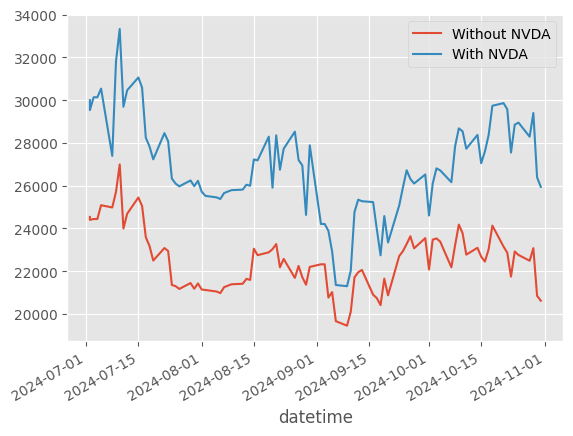

In [168]:
eq = evb_backtest.portfolio._equity.copy()
(eq['Total'] - eq['NVDA']).plot()
eq['Total'].plot(legend = 'With NVDA')
plt.legend(['Without NVDA', 'With NVDA'])
plt.show()


In [169]:
evb_backtest.portfolio.aggregate()

Start                                                    2024-07-02 00:00:00
End                                                      2024-10-31 00:00:00
Duration                                                   121 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    25943.95
Equity Peak [$]                                                 33328.574849
Return [%]                                                        -13.520183
Buy & Hold Return [%]                                               0.442563
CAGR [%]                                                          -35.478931
Volatility Ann. [%]                                                82.756077
Sharpe Ratio                                                       -0.120719
Sortino Ratio                                                      -0.171336
Skew                                                                0.203911

In [170]:
evb_backtest.portfolio.get_trades()

,Ticker,PnL,ReturnPct,EntryPrice,EntryCommission,EntrySlippage,EntryMarketValue,TotalEntryCost,AuxilaryEntryCost,ExitPrice,ExitCommission,ExitSlippage,ExitMarketValue,TotalExitCost,AuxilaryExitCost,Quantity,EntryTime,ExitTime,Duration,Positions
0,QCOM,-278.883084,-30.018633,132.719038,9.1,44.933267,919.933267,983.066534,-63.133267,92.878598,9.1,-23.249817,659.250183,636.000366,23.249817,7,2024-07-02,2024-07-24,22,&L:QCOM20250117C260&S:QCOM20250117C270
1,NVDA,-662.803442,-12.928205,160.212551,41.6,285.201620,5085.201620,5453.603240,-368.401620,139.499943,41.6,-134.401822,4505.598178,4371.196356,134.401822,32,2024-07-02,2024-07-25,23,&L:NVDA20250117C130&S:NVDA20250117C134
2,AAPL,-183.800906,-14.477103,158.699658,10.4,75.197266,1259.197266,1355.194532,-95.997266,135.724545,10.4,-47.803640,1096.196360,1048.392720,47.803640,8,2024-07-02,2024-08-05,34,&L:AAPL20250117C265&S:AAPL20250117C280
3,TSLA,-1666.584511,-74.991738,158.739822,18.2,125.157506,2204.157506,2365.715011,-161.557506,39.698071,18.2,-14.027006,573.972994,559.945988,14.027006,14,2024-07-03,2024-08-02,30,&L:TSLA20250117C490&S:TSLA20250117C550
4,AMZN,-266.850846,-33.956568,157.171860,6.5,29.359301,779.359301,821.718603,-42.359301,103.801691,6.5,-41.991544,525.508456,483.516911,41.991544,5,2024-07-08,2024-07-17,9,&L:AMZN20250117C245&S:AMZN20250117C255
5,WMT,-36.238985,-25.102132,144.366167,1.3,3.566167,143.066167,149.232334,-6.166167,108.127182,1.3,-6.572818,109.427182,102.854364,6.572818,1,2024-07-08,2024-08-05,28,&L:WMT20250117C76.67&S:WMT20250117C86.67
6,MSFT,-343.975959,-20.394082,153.331454,14.3,60.845993,1672.345993,1761.791986,-89.445993,122.060912,14.3,-34.529966,1356.970034,1322.440068,34.529966,11,2024-07-09,2024-07-16,7,&L:MSFT20250117C600&S:MSFT20250117C640
7,GOOG,-582.150286,-51.803606,160.537719,9.1,64.664031,1114.664031,1197.528063,-82.864031,77.373392,9.1,-26.786254,550.713746,523.927491,26.786254,7,2024-07-09,2024-07-17,8,&L:GOOG20250117C210&S:GOOG20250117C215
8,AMZN,489.542331,76.522811,159.933465,5.2,34.533859,634.533859,679.467718,-44.933859,282.319047,5.2,-65.523810,1134.476190,1068.952379,65.523810,4,2024-07-19,2024-08-02,14,&L:AMZN20250117C205&S:AMZN20250117C210
9,HD,-25.818079,-8.856211,145.762564,2.6,13.925128,288.925128,308.050256,-19.125128,132.853524,2.6,-6.692952,268.307048,261.614097,6.692952,2,2024-07-23,2024-07-24,1,&L:HD20250117C420&S:HD20250117C430


In [128]:
len('&L:NVDA20250321C190&S:NVDA20250321C205'.split('&')) - 1

2

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [125]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')